In [1]:
# STEP 1: Install Required Packages
!pip install shap -q
!pip install scikit-learn pandas matplotlib seaborn tensorflow -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\Tushar\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# STEP 2: Load and Clean Data
df = pd.read_csv(r"C:\Users\Tushar\Desktop\Msc in data analytis projects\Sem 2\domain applications\train data complete\dataset_train01.csv")  # Replace with your actual file path
df.head()
# Drop non-sensor columns if not needed
df = df.drop(columns=['timestamp', 'gpsLong', 'gpsLat', 'gpsSpeed'], errors='ignore')

# Handle missing values
df = df.fillna(method='ffill')

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

print("Scaled data shape:", scaled_data.shape)


C:\Users\Tushar\AppData\Local\Temp\ipykernel_22128\4159220685.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


Scaled data shape: (712809, 17)


In [3]:
# STEP 3: Create Windowed Sequences for Time-Series

def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        window = data[i:i+window_size]
        sequences.append(window)
    return np.array(sequences)

# Set your window size (e.g., 30 seconds of past data)
WINDOW_SIZE = 30  # You can tune this
sequence_data = create_sequences(scaled_data, WINDOW_SIZE)

print("Sequence data shape:", sequence_data.shape)


Sequence data shape: (712779, 30, 17)


In [4]:
from tensorflow.keras.layers import TimeDistributed, Flatten, Reshape

# STEP 4: Define Sparse Autoencoder for Time-Series Data

timesteps = sequence_data.shape[1]
n_features = sequence_data.shape[2]

# Encoder
input_layer = Input(shape=(timesteps, n_features))
x = TimeDistributed(Dense(32, activation='relu',
              activity_regularizer=regularizers.l1(1e-5)))(input_layer)
x = TimeDistributed(Dense(16, activation='relu'))(x)

# Decoder
x = TimeDistributed(Dense(32, activation='relu'))(x)
output_layer = TimeDistributed(Dense(n_features, activation='sigmoid'))(x)

# Model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30, 17)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 30, 32)              │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 30, 16)              │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 30, 32)              │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 30, 17)              │             561 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,209 (8.63 KB)

 Trainable params: 2,209 (8.63 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train-test split
X_train, X_test = train_test_split(sequence_data, test_size=0.2, random_state=42)

# Train the model
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_test, X_test),
    shuffle=True,
    verbose=1
)


Epoch 1/50
4455/4455 ━━━━━━━━━━━━━━━━━━━━ 97s 21ms/step - loss: 0.0134 - val_loss: 1.0425e-04
Epoch 2/50
4455/4455 ━━━━━━━━━━━━━━━━━━━━ 90s 20ms/step - loss: 8.6654e-05 - val_loss: 4.5451e-05
Epoch 3/50
4455/4455 ━━━━━━━━━━━━━━━━━━━━ 77s 17ms/step - loss: 4.0736e-05 - val_loss: 2.8792e-05
Epoch 4/50
4455/4455 ━━━━━━━━━━━━━━━━━━━━ 75s 17ms/step - loss: 2.9170e-05 - val_loss: 2.3721e-05
Epoch 5/50
4455/4455 ━━━━━━━━━━━━━━━━━━━━ 73s 16ms/step - loss: 2.2572e-05 - val_loss: 1.9270e-05
Epoch 6/50
4455/4455 ━━━━━━━━━━━━━━━━━━━━ 74s 17ms/step - loss: 1.9269e-05 - val_loss: 1.7616e-05
Epoch 7/50
4455/4455 ━━━━━━━━━━━━━━━━━━━━ 77s 17ms/step - loss: 1.7419e-05 - val_loss: 1.5150e-05
Epoch 8/50
4455/4455 ━━━━━━━━━━━━━━━━━━━━ 76s 17ms/step - loss: 1.6124e-05 - val_loss: 1.4140e-05
Epoch 9/50
4455/4455 ━━━━━━━━━━━━━━━━━━━━ 75s 17ms/step - loss: 1.5081e-05 - val_loss: 1.4578e-05
Epoch 10/50
4455/4455 ━━━━━━━━━━━━━━━━━━━━ 73s 16ms/step - loss: 1.4377e-05 - val_loss: 1.4049e-05
Epoch 11/50
4455/4455 ━

4455/4455 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


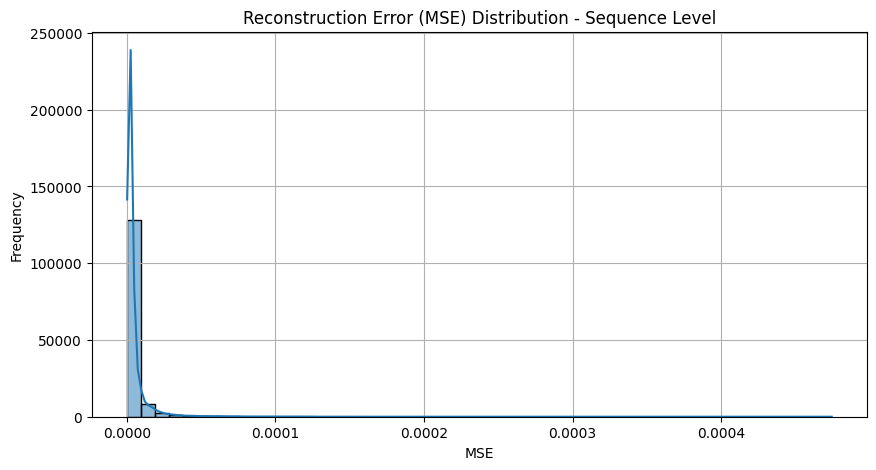

Anomaly threshold (95%): 1.7318956256801736e-05
Anomalies Detected: 7128 out of 142556


In [6]:
# Predict on test data
X_pred = autoencoder.predict(X_test)

# Reconstruction error (MSE) for each sequence
mse_seq = np.mean(np.power(X_test - X_pred, 2), axis=(1, 2))  # Mean across all features and timesteps

# Plot distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.histplot(mse_seq, bins=50, kde=True)
plt.title("Reconstruction Error (MSE) Distribution - Sequence Level")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Set anomaly threshold (95th percentile)
threshold = np.percentile(mse_seq, 95)
print("Anomaly threshold (95%):", threshold)

# Detect anomalies
anomalies = mse_seq > threshold
print(f"Anomalies Detected: {np.sum(anomalies)} out of {len(mse_seq)}")


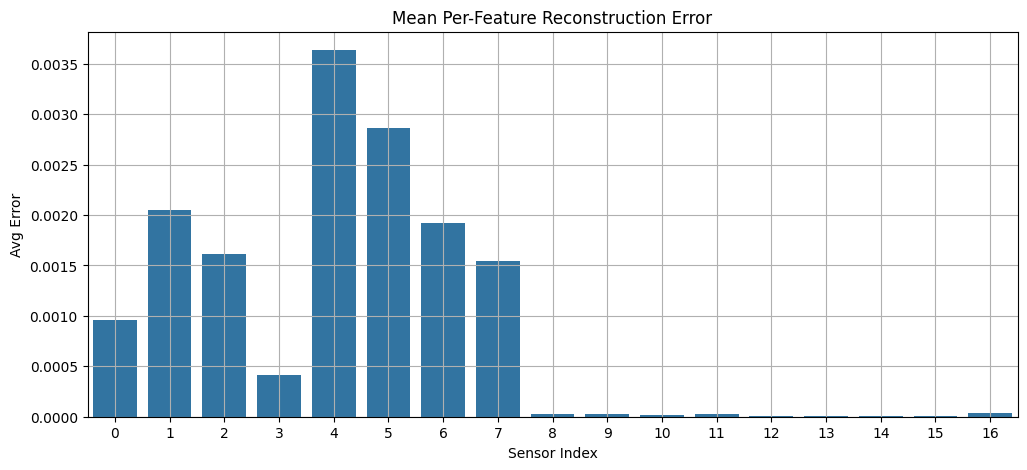

In [7]:
# Mean absolute error for each feature across all test samples
per_feature_error = np.mean(np.abs(X_test - X_pred), axis=(0, 1))

# Visualize
plt.figure(figsize=(12, 5))
sns.barplot(x=np.arange(n_features), y=per_feature_error)
plt.title("Mean Per-Feature Reconstruction Error")
plt.xlabel("Sensor Index")
plt.ylabel("Avg Error")
plt.grid(True)
plt.show()


Silhouette Score: 0.34570397384655843


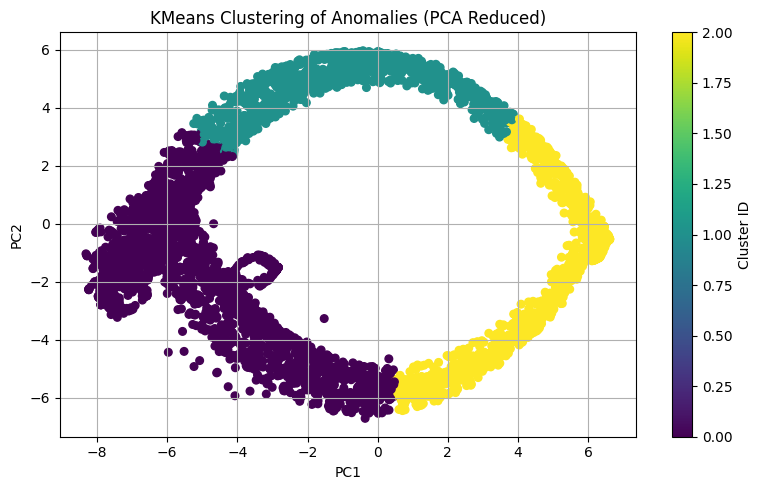

In [8]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# STEP 8: KMeans Clustering on Anomalies

# Get only anomalous sequences
anomalous_sequences = X_test[anomalies]

# Flatten each sequence (timesteps × features)
anomalous_flat = anomalous_sequences.reshape(anomalous_sequences.shape[0], -1)

# Optional: reduce dimension with PCA
pca = PCA(n_components=10)
anomalous_pca = pca.fit_transform(anomalous_flat)

# Use KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(anomalous_pca)

# Evaluate clustering quality
sil_score = silhouette_score(anomalous_pca, cluster_labels)
print("Silhouette Score:", sil_score)

# Visualize clusters
plt.figure(figsize=(8, 5))
plt.scatter(anomalous_pca[:, 0], anomalous_pca[:, 1], c=cluster_labels, cmap='viridis', s=30)
plt.title("KMeans Clustering of Anomalies (PCA Reduced)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.colorbar(label="Cluster ID")
plt.tight_layout()
plt.show()


In [15]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Flatten input and predicted output
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_pred_flat = autoencoder.predict(X_test).reshape(X_test.shape[0], -1)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(X_test_flat, X_pred_flat))
print("✅ RMSE on Test Data:", rmse)


4455/4455 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
✅ RMSE on Test Data: 0.002267874641340349


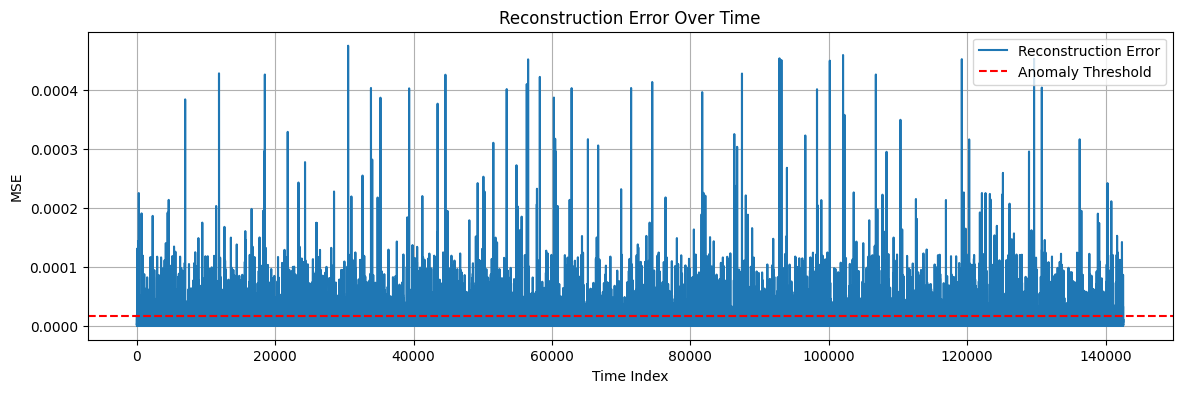

In [10]:
plt.figure(figsize=(14, 4))
plt.plot(mse_seq, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.title("Reconstruction Error Over Time")
plt.xlabel("Time Index")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()


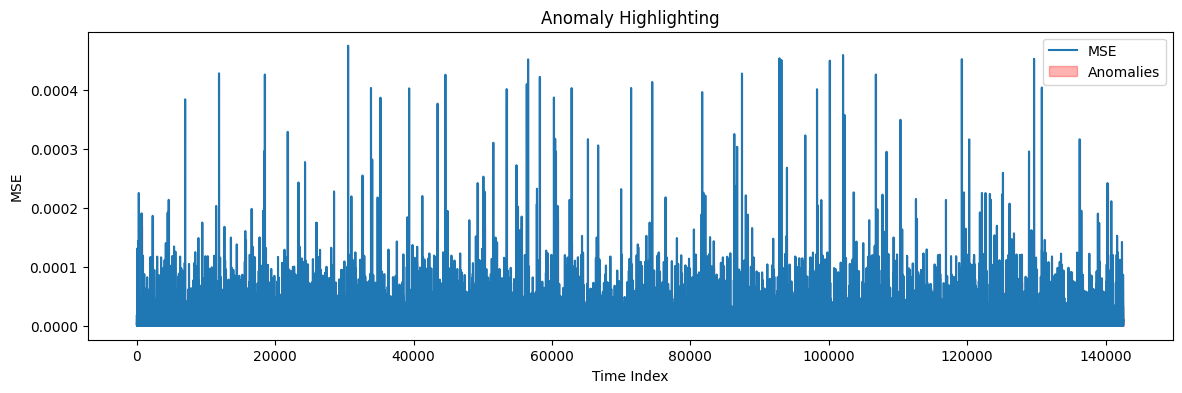

In [11]:
plt.figure(figsize=(14, 4))
plt.plot(mse_seq, label='MSE')
plt.fill_between(range(len(mse_seq)), 0, mse_seq,
                 where=mse_seq > threshold, color='red', alpha=0.3, label='Anomalies')
plt.title("Anomaly Highlighting")
plt.xlabel("Time Index")
plt.ylabel("MSE")
plt.legend()
plt.show()


In [17]:
import numpy as np

# Compute per-feature reconstruction error per sample
reconstruction_errors = np.mean((X_test - X_pred) ** 2, axis=1)  # shape: (n_samples, n_features)


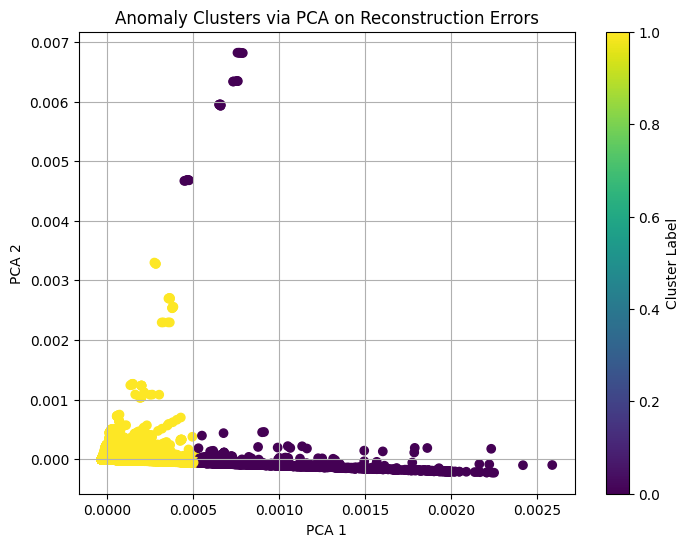

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(reconstruction_errors)

# Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title("Anomaly Clusters via PCA on Reconstruction Errors")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()


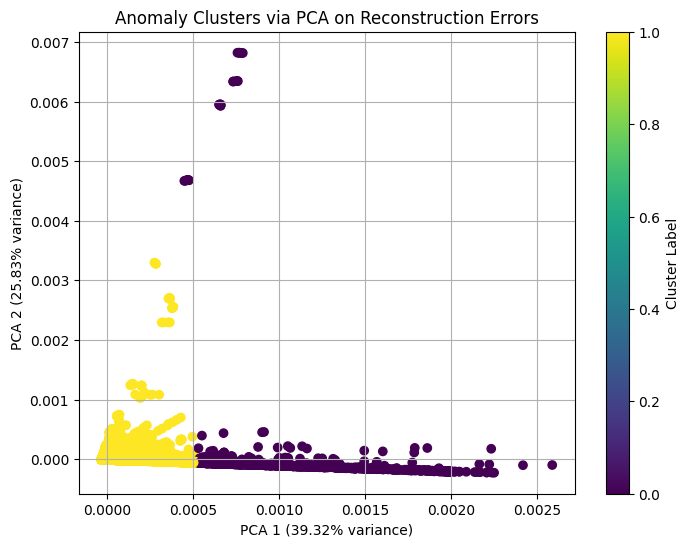

,Sensor_0,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16
0,0.000022,0.000017,0.000141,0.000005,0.001079,0.000051,0.000010,0.000009,5.786516e-07,1.483214e-07,1.111084e-07,5.646511e-07,5.075327e-08,5.400732e-11,4.254750e-11,1.514033e-07,6.017278e-08
1,0.000007,0.000009,0.000007,0.000002,0.000022,0.000016,0.000009,0.000005,7.431920e-09,6.440114e-09,6.157316e-08,3.444952e-09,1.406338e-08,1.426791e-10,1.216485e-10,1.406592e-08,8.125661e-09


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd

# Compute per-feature reconstruction error per sample
reconstruction_errors = np.mean((X_test - X_pred) ** 2, axis=1)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(reconstruction_errors)
explained_variance = pca.explained_variance_ratio_ * 100  # convert to %

# KMeans Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

# Plotting PCA Scatter with variance-labeled axes
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title("Anomaly Clusters via PCA on Reconstruction Errors")
plt.xlabel(f"PCA 1 ({explained_variance[0]:.2f}% variance)")
plt.ylabel(f"PCA 2 ({explained_variance[1]:.2f}% variance)")
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

# Link back cluster IDs to sensor error profiles
cluster_profiles = {}
for cluster_id in np.unique(cluster_labels):
    cluster_profiles[cluster_id] = reconstruction_errors[cluster_labels == cluster_id].mean(axis=0)

# Display cluster-wise sensor error profiles
cluster_profiles_df = pd.DataFrame(cluster_profiles).T
cluster_profiles_df.columns = [f"Sensor_{i}" for i in range(cluster_profiles_df.shape[1])]
display(cluster_profiles_df)


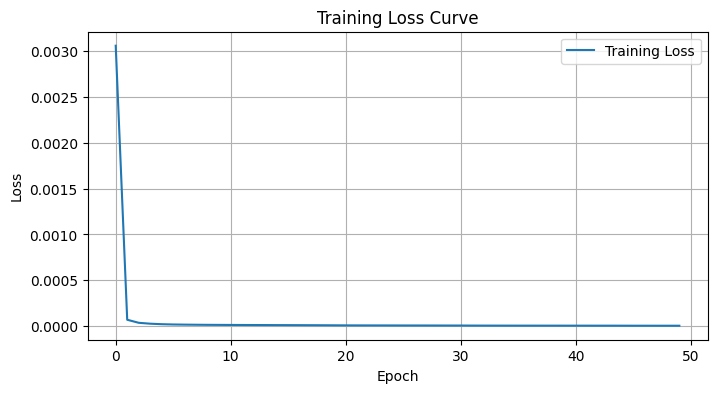

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


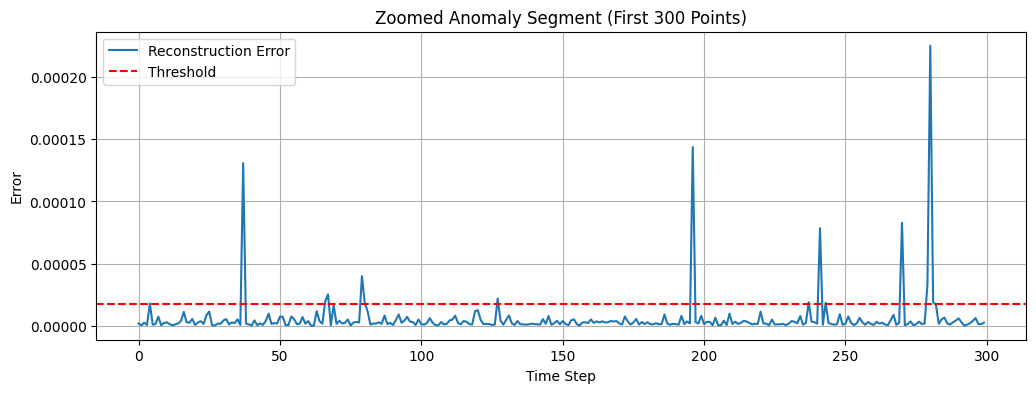

In [20]:
plt.figure(figsize=(12, 4))
plt.plot(mse_seq[:300], label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Zoomed Anomaly Segment (First 300 Points)')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()


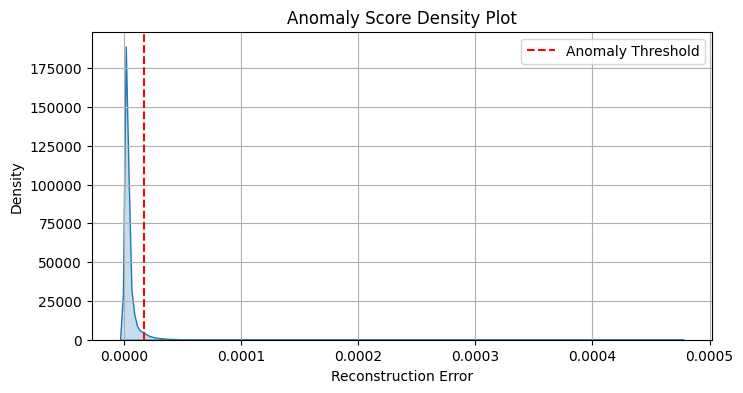

In [23]:
plt.figure(figsize=(8, 4))
sns.kdeplot(mse_seq, fill=True)
plt.axvline(x=threshold, color='red', linestyle='--', label='Anomaly Threshold')
plt.title('Anomaly Score Density Plot')
plt.xlabel('Reconstruction Error')
plt.legend()
plt.grid(True)
plt.show()


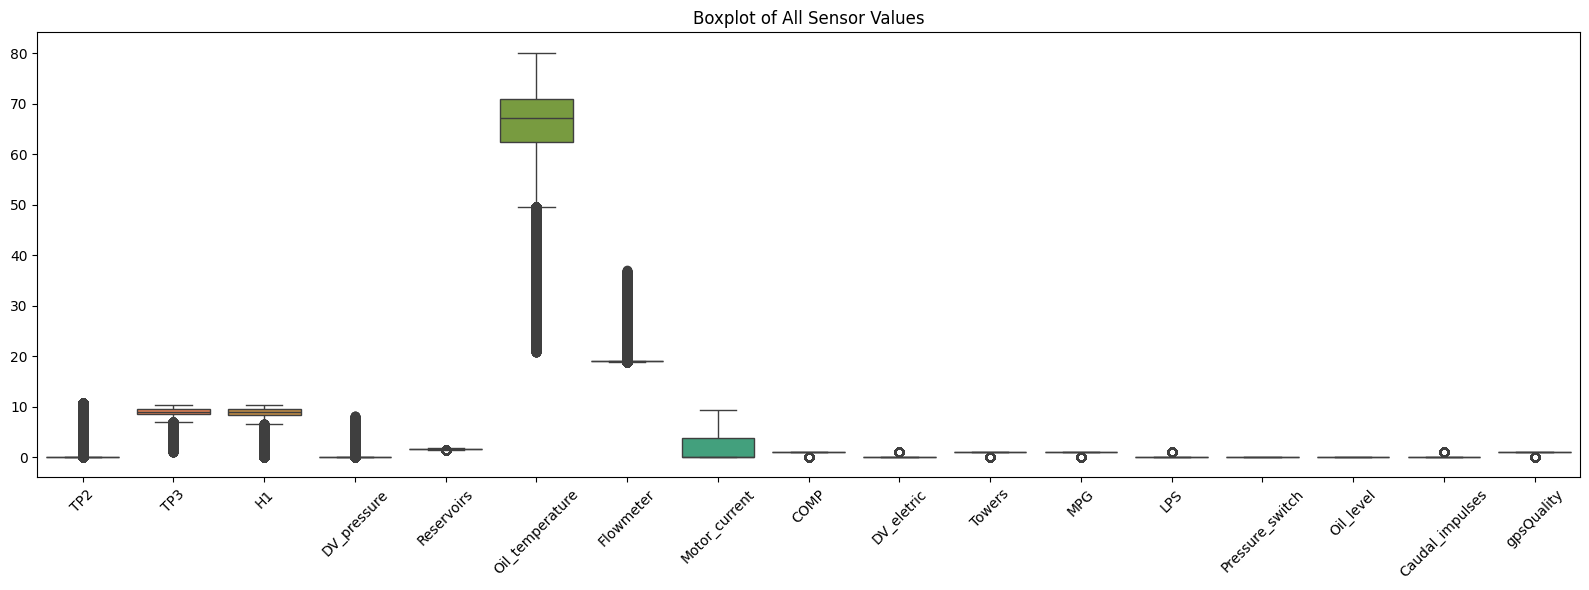

In [26]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title("Boxplot of All Sensor Values")
plt.tight_layout()
plt.show()


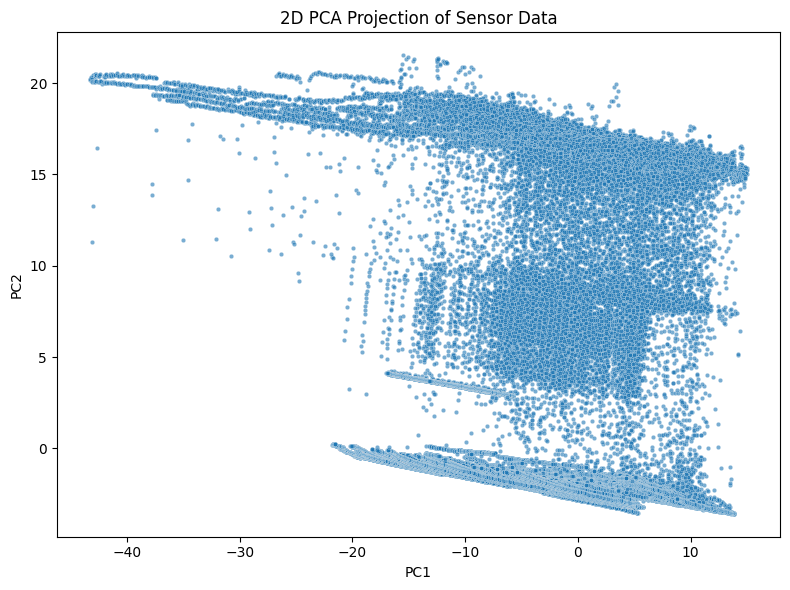

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, s=10, alpha=0.6)
plt.title("2D PCA Projection of Sensor Data")
plt.tight_layout()
plt.show()


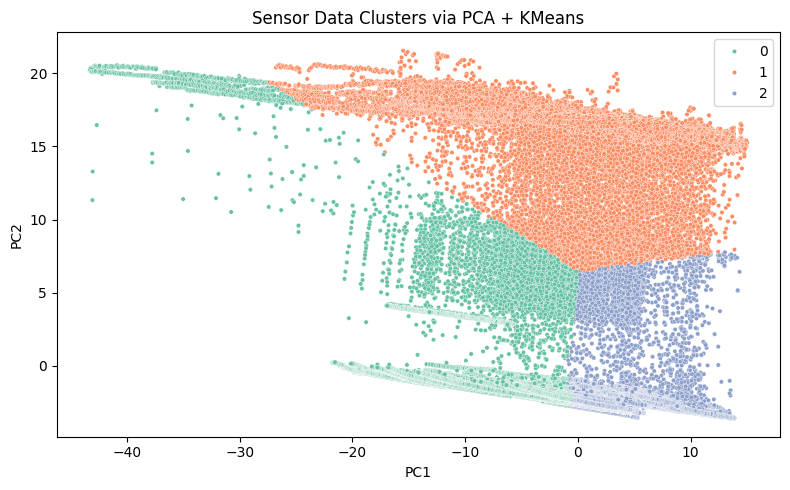

In [28]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(df)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=clusters, palette='Set2', s=10)
plt.title("Sensor Data Clusters via PCA + KMeans")
plt.tight_layout()
plt.show()
